In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/lungvision/resnet.h5
/kaggle/input/lungvision/inception_training.h5
/kaggle/input/lungvision/dataset/dataset/val/tb/CHNCXR_0629_1.png
/kaggle/input/lungvision/dataset/dataset/val/tb/CHNCXR_0618_1.png
/kaggle/input/lungvision/dataset/dataset/val/tb/CHNCXR_0410_1.png
/kaggle/input/lungvision/dataset/dataset/val/tb/CHNCXR_0462_1.png
/kaggle/input/lungvision/dataset/dataset/val/tb/Tuberculosis-675.png
/kaggle/input/lungvision/dataset/dataset/val/tb/CHNCXR_0349_1.png
/kaggle/input/lungvision/dataset/dataset/val/tb/Tuberculosis-556.png
/kaggle/input/lungvision/dataset/dataset/val/tb/Tuberculosis-508.png
/kaggle/input/lungvision/dataset/dataset/val/tb/CHNCXR_0646_1.png
/kaggle/input/lungvision/dataset/dataset/val/tb/Tuberculosis-684.png
/kaggle/input/lungvision/dataset/dataset/val/tb/Tuberculosis-25.png
/kaggle/input/lungvision/dataset/dataset/val/tb/Tuberculosis-382.png
/kaggle/input/lungvision/dataset/dataset/val/tb/Tuberculosis-41.png
/kaggle/input/lungvision/dataset/dataset/

In [2]:
# --- 1. IMPORT LIBRARIES ---
print("Importing libraries...")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2 # OpenCV
from glob import glob

# Scikit-learn (ML)
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_curve, auc, RocCurveDisplay,
    precision_recall_fscore_support
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import label_binarize
from sklearn.utils.class_weight import compute_class_weight

# TensorFlow & Keras (DL)
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
)
from tensorflow.keras.applications import ResNet50, VGG16, InceptionV3
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

print("Libraries imported successfully.")

Importing libraries...


2025-10-20 05:41:03.961018: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760938864.168920      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760938864.220548      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Libraries imported successfully.


In [6]:
# --- 2. SETUP PATHS AND PARAMETERS ---
print("\n--- Setting up configuration ---")

# Base directory corrected based on your file path:
BASE_DIR = '/kaggle/input/lungvision/dataset/dataset/' 
TRAIN_DIR = os.path.join(BASE_DIR, 'train')
VAL_DIR = os.path.join(BASE_DIR, 'val')
TEST_DIR = os.path.join(BASE_DIR, 'test')

# Model parameters
IMG_SIZE = (150, 150) # Using 150x150 for faster training
BATCH_SIZE = 32
CLASSES = ['normal', 'pnemo', 'tb']
N_CLASSES = len(CLASSES)

print(f"Base directory: {BASE_DIR}")
print(f"Train directory: {TRAIN_DIR}")
print(f"Classes: {CLASSES} (Total: {N_CLASSES})")


--- Setting up configuration ---
Base directory: /kaggle/input/lungvision/dataset/dataset/
Train directory: /kaggle/input/lungvision/dataset/dataset/train
Classes: ['normal', 'pnemo', 'tb'] (Total: 3)



--- Starting EDA ---
Train images: {'normal': 5256, 'pnemo': 4042, 'tb': 765}
Validation images: {'normal': 1501, 'pnemo': 1155, 'tb': 218}
Test images: {'normal': 752, 'pnemo': 578, 'tb': 111}


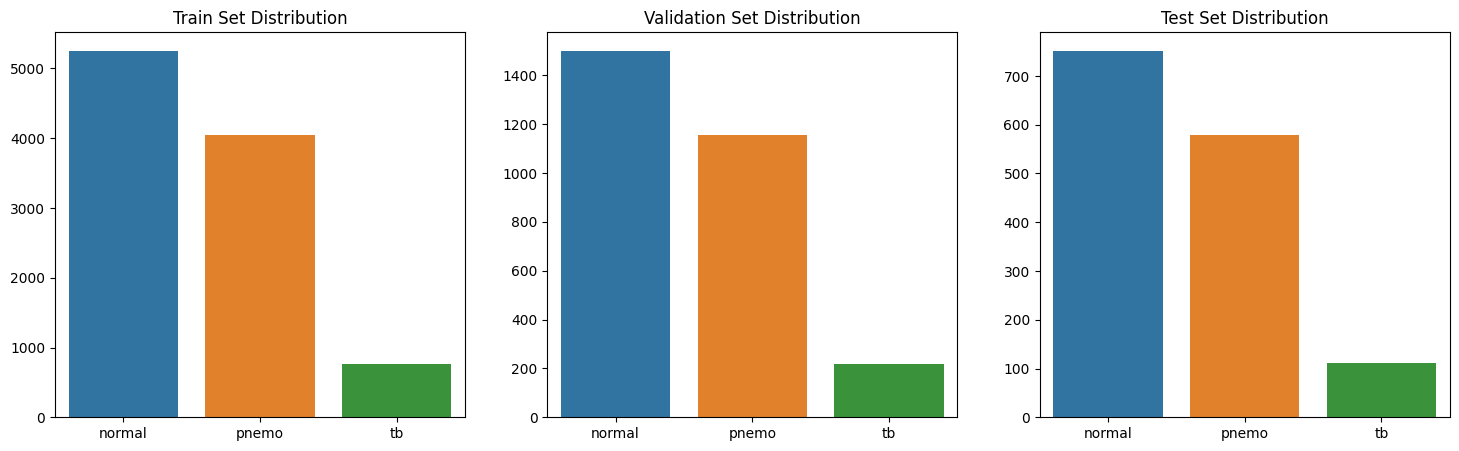


--- Displaying Sample Images ---


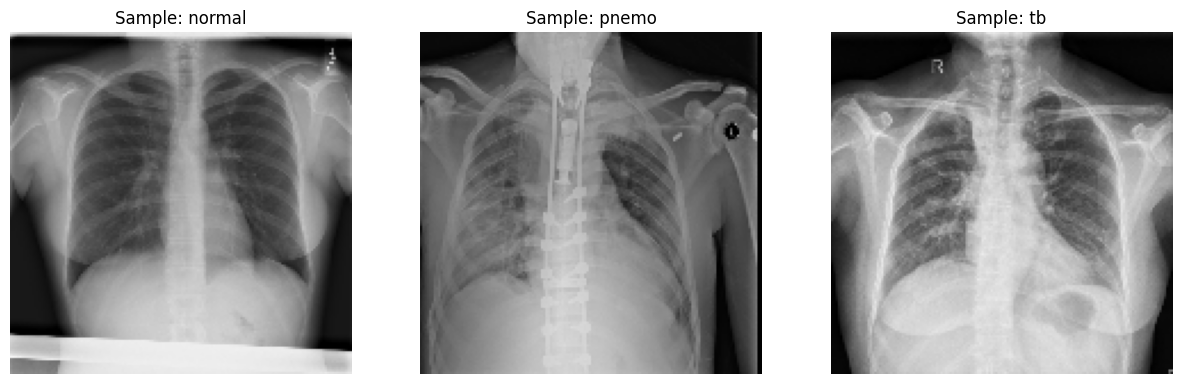

In [7]:
# --- 3. EXPLORATORY DATA ANALYSIS (EDA) ---
print("\n--- Starting EDA ---")

# Function to count files
def count_images(directory):
    counts = {}
    for cls in CLASSES:
        class_path = os.path.join(directory, cls)
        # Check if path exists and is a directory
        if os.path.isdir(class_path):
            # Use glob to find all .png files as confirmed by your path
            count = len(glob(os.path.join(class_path, '*.png'))) 
            counts[cls] = count
        else:
            print(f"Warning: Directory not found {class_path}")
            counts[cls] = 0
    return counts

train_counts = count_images(TRAIN_DIR)
val_counts = count_images(VAL_DIR)
test_counts = count_images(TEST_DIR)

print(f"Train images: {train_counts}")
print(f"Validation images: {val_counts}")
print(f"Test images: {test_counts}")

# Plotting the distribution
fig, ax = plt.subplots(1, 3, figsize=(18, 5))
sns.barplot(x=list(train_counts.keys()), y=list(train_counts.values()), ax=ax[0]).set_title('Train Set Distribution')
sns.barplot(x=list(val_counts.keys()), y=list(val_counts.values()), ax=ax[1]).set_title('Validation Set Distribution')
sns.barplot(x=list(test_counts.keys()), y=list(test_counts.values()), ax=ax[2]).set_title('Test Set Distribution')
plt.show()

# Show sample images
print("\n--- Displaying Sample Images ---")
plt.figure(figsize=(15, 6))
for i, cls in enumerate(CLASSES):
    plt.subplot(1, N_CLASSES, i+1)
    # Find the first .png file in the class directory
    img_path = glob(os.path.join(TRAIN_DIR, cls, '*.png'))[0]
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, IMG_SIZE)
    plt.imshow(img)
    plt.title(f"Sample: {cls}")
    plt.axis('off')
plt.show()

In [8]:
# --- 4. DATA PREPROCESSING (DEEP LEARNING) ---
# Create DataGenerators for DL models
print("\n--- Creating Data Generators for Deep Learning ---")

# With Data Augmentation for Training
train_datagen = ImageDataGenerator(
    rescale=1./255,            # Normalize pixel values
    rotation_range=20,       
    width_shift_range=0.1,   
    height_shift_range=0.1,  
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,    
    fill_mode='nearest'
)

# Only rescaling for Validation and Testing
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Create iterators
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical', # 3 classes
    classes=CLASSES,
    shuffle=True
)

validation_generator = validation_datagen.flow_from_directory(
    VAL_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical', # 3 classes
    classes=CLASSES,
    shuffle=False # Important for validation
)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical', # 3 classes
    classes=CLASSES,
    shuffle=False # Important for testing
)

print(f"Class indices: {train_generator.class_indices}")

# Calculate class weights to handle imbalance
# Get labels from the generator
train_labels = train_generator.classes
# Calculate weights
class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)
# Convert to a dictionary for Keras
class_weights = dict(enumerate(class_weights_array))

print(f"Calculated Class Weights: {class_weights}")


--- Creating Data Generators for Deep Learning ---
Found 10063 images belonging to 3 classes.
Found 2874 images belonging to 3 classes.
Found 1441 images belonging to 3 classes.
Class indices: {'normal': 0, 'pnemo': 1, 'tb': 2}
Calculated Class Weights: {0: 0.6381912734652461, 1: 0.8298697014679202, 2: 4.3847494553376904}


In [ ]:
# --- 5. "CLASSIC" MACHINE LEARNING MODEL ---
print("\n--- Preparing for 'Classic' ML (Random Forest) ---")

# 5.1. Feature Extraction
# We use a pre-trained model (VGG16) as a feature extractor.

print("Loading VGG16 for feature extraction...")
base_model_vgg = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
feature_extractor = Model(inputs=base_model_vgg.input, outputs=GlobalAveragePooling2D()(base_model_vgg.output))

feature_extractor.save('vgg16_feature_extractor.h5')
print("--- vgg16_feature_extractor.h5 model has been saved to /kaggle/working/ ---")

# Create generators *without augmentation* to get clean features
feat_datagen = ImageDataGenerator(rescale=1./255)

train_feat_gen = feat_datagen.flow_from_directory(
    TRAIN_DIR, target_size=IMG_SIZE, batch_size=BATCH_SIZE, 
    class_mode='categorical', classes=CLASSES, shuffle=False)
    
val_feat_gen = feat_datagen.flow_from_directory(
    VAL_DIR, target_size=IMG_SIZE, batch_size=BATCH_SIZE, 
    class_mode='categorical', classes=CLASSES, shuffle=False)
    
test_feat_gen = feat_datagen.flow_from_directory(
    TEST_DIR, target_size=IMG_SIZE, batch_size=BATCH_SIZE, 
    class_mode='categorical', classes=CLASSES, shuffle=False)

print("Extracting features (this may take a minute)...")
# Predict features
X_train_features = feature_extractor.predict(train_feat_gen, steps=len(train_feat_gen))
X_val_features = feature_extractor.predict(val_feat_gen, steps=len(val_feat_gen))
X_test_features = feature_extractor.predict(test_feat_gen, steps=len(test_feat_gen))

# Get labels (as integers, not one-hot)
y_train = train_feat_gen.classes
y_val = val_feat_gen.classes
y_test = test_feat_gen.classes # This will be our ground truth for all models

print(f"Train features shape: {X_train_features.shape}, Labels shape: {y_train.shape}")
print(f"Test features shape: {X_test_features.shape}, Labels shape: {y_test.shape}")

# 5.2. Train Random Forest
print("\n--- Training Random Forest Classifier ---")
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, class_weight='balanced')
rf_model.fit(X_train_features, y_train)

# Validate
print("Random Forest Validation Report:")
y_pred_rf_val = rf_model.predict(X_val_features)
print(classification_report(y_val, y_pred_rf_val, target_names=CLASSES))

# Store test predictions for final comparison
y_pred_test_rf = rf_model.predict(X_test_features)
y_prob_test_rf = rf_model.predict_proba(X_test_features)


--- Preparing for 'Classic' ML (Random Forest) ---
Loading VGG16 for feature extraction...


2025-10-20 05:47:57.712430: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
Found 10063 images belonging to 3 classes.
Found 2874 images belonging to 3 classes.
Found 1441 images belonging to 3 classes.
Extracting features (this may take a minute)...
315/315 ━━━━━━━━━━━━━━━━━━━━ 832s 3s/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 243s 3s/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 120s 3s/step
Train features shape: (10063, 512), Labels shape: (10063,)
Test features shape: (1441, 512), Labels shape: (1441,)

--- Training Random Forest Classifier ---
Random Forest Validation Report:
              precision    recall  f1-score   support

      normal       0.83      0.92      0.87      1501
       pnemo       0.88      0.81      0.84      1155
          tb       0.97      0.61      0.75       218

    accuracy                           0.85      2874
   macro avg       0.89      0.78      0.82      2874
weighted avg       0.86      0.85      0.85      2874



In [12]:
# --- 6. SIMPLE DEEP LEARNING MODEL (CNN from Scratch) ---
print("\n--- Building Simple CNN Model ---")

simple_cnn = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(N_CLASSES, activation='softmax') # 3 outputs, softmax
])

simple_cnn.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy', # 3 classes
    metrics=['accuracy']
)

simple_cnn.summary()

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5)

print("\n--- Training Simple CNN Model ---")
history_cnn = simple_cnn.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=10, # Set high, EarlyStopping will handle it
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    callbacks=[early_stopping, reduce_lr],
    class_weight=class_weights # Use class weights
)

print("\n--- Evaluating Simple CNN on Test Set ---")
y_prob_test_cnn = simple_cnn.predict(test_generator)
y_pred_test_cnn = np.argmax(y_prob_test_cnn, axis=1)

# Ensure prediction length matches y_test
if len(y_pred_test_cnn) != len(y_test):
    print(f"Adjusting CNN predictions. Original: {len(y_pred_test_cnn)}, Target: {len(y_test)}")
    y_prob_test_cnn = y_prob_test_cnn[:len(y_test)]
    y_pred_test_cnn = y_pred_test_cnn[:len(y_test)]


--- Building Simple CNN Model ---


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 148, 148, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 72, 72, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 34, 34, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │     9,470,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,565,123 (36.49 MB)

 Trainable params: 9,564,675 (36.49 MB)

 Non-trainable params: 448 (1.75 KB)


--- Training Simple CNN Model ---
Epoch 1/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 366s 1s/step - accuracy: 0.5707 - loss: 6.1142 - val_accuracy: 0.3775 - val_loss: 3.3772 - learning_rate: 0.0010
Epoch 2/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 27s 84ms/step - accuracy: 0.6562 - loss: 1.2777 - val_accuracy: 0.4105 - val_loss: 3.1987 - learning_rate: 0.0010
Epoch 3/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 416s 1s/step - accuracy: 0.6731 - loss: 1.2937 - val_accuracy: 0.7630 - val_loss: 0.7715 - learning_rate: 0.0010
Epoch 4/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 27s 83ms/step - accuracy: 0.6562 - loss: 0.7409 - val_accuracy: 0.7556 - val_loss: 0.7643 - learning_rate: 0.0010
Epoch 5/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 339s 1s/step - accuracy: 0.7140 - loss: 0.7773 - val_accuracy: 0.6605 - val_loss: 0.9198 - learning_rate: 0.0010
Epoch 6/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 27s 84ms/step - accuracy: 0.6250 - loss: 0.5605 - val_accuracy: 0.6541 - val_loss: 0.9487 - learning_rate: 0.0010
Epoch 7/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 359s

In [13]:
# --- 5.5. TRAIN MORE "CLASSIC" ML MODELS ---
print("\n--- Training Additional ML Models ---")
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import lightgbm as lgb # A powerful gradient boosting model

# We already have these from Cell 5:
# X_train_features, y_train
# X_val_features, y_val
# X_test_features, y_test

# --- 1. Logistic Regression ---
print("\n--- Training Logistic Regression ---")
# Using a pipeline to scale data first
lr_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('log_reg', LogisticRegression(multi_class='ovr', solver='liblinear', random_state=42, class_weight='balanced'))
])
lr_pipeline.fit(X_train_features, y_train)

print("Logistic Regression Validation Report:")
y_pred_lr_val = lr_pipeline.predict(X_val_features)
print(classification_report(y_val, y_pred_lr_val, target_names=CLASSES))

# Store test predictions
y_pred_test_lr = lr_pipeline.predict(X_test_features)
y_prob_test_lr = lr_pipeline.predict_proba(X_test_features)

# --- 2. Support Vector Machine (SVC) ---
print("\n--- Training Support Vector Machine (SVC) ---")
# SVMs are very sensitive to scaling
svm_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(kernel='rbf', probability=True, random_state=42, class_weight='balanced')) 
])
svm_pipeline.fit(X_train_features, y_train)

print("SVC Validation Report:")
y_pred_svm_val = svm_pipeline.predict(X_val_features)
print(classification_report(y_val, y_pred_svm_val, target_names=CLASSES))

# Store test predictions
y_pred_test_svm = svm_pipeline.predict(X_test_features)
y_prob_test_svm = svm_pipeline.predict_proba(X_test_features)

# --- 3. K-Nearest Neighbors (KNN) ---
print("\n--- Training K-Nearest Neighbors (KNN) ---")
knn_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier(n_neighbors=5, n_jobs=-1)) # Using 5 neighbors as a default
])
knn_pipeline.fit(X_train_features, y_train)

print("KNN Validation Report:")
y_pred_knn_val = knn_pipeline.predict(X_val_features)
print(classification_report(y_val, y_pred_knn_val, target_names=CLASSES))

# Store test predictions
y_pred_test_knn = knn_pipeline.predict(X_test_features)
y_prob_test_knn = knn_pipeline.predict_proba(X_test_features)

# --- 4. LightGBM Classifier ---
print("\n--- Training LightGBM Classifier ---")
# Tree-based models like LightGBM don't require scaling
lgbm_model = lgb.LGBMClassifier(random_state=42, n_jobs=-1, class_weight='balanced', objective='multiclass')
lgbm_model.fit(X_train_features, y_train)

print("LightGBM Validation Report:")
y_pred_lgbm_val = lgbm_model.predict(X_val_features)
print(classification_report(y_val, y_pred_lgbm_val, target_names=CLASSES))

# Store test predictions
y_pred_test_lgbm = lgbm_model.predict(X_test_features)
y_prob_test_lgbm = lgbm_model.predict_proba(X_test_features)

print("\n--- All ML models trained. ---")


--- Training Additional ML Models ---

--- Training Logistic Regression ---
Logistic Regression Validation Report:
              precision    recall  f1-score   support

      normal       0.88      0.90      0.89      1501
       pnemo       0.89      0.85      0.87      1155
          tb       0.80      0.84      0.82       218

    accuracy                           0.88      2874
   macro avg       0.85      0.86      0.86      2874
weighted avg       0.88      0.88      0.88      2874


--- Training Support Vector Machine (SVC) ---
SVC Validation Report:
              precision    recall  f1-score   support

      normal       0.88      0.90      0.89      1501
       pnemo       0.89      0.85      0.87      1155
          tb       0.78      0.91      0.84       218

    accuracy                           0.88      2874
   macro avg       0.85      0.88      0.87      2874
weighted avg       0.88      0.88      0.88      2874


--- Training K-Nearest Neighbors (KNN) ---
KNN Vali


 FINAL MODEL COMPARISON ON TEST SET

--- Classification Report: Random Forest ---
              precision    recall  f1-score   support

      normal       0.84      0.92      0.88       752
       pnemo       0.88      0.83      0.85       578
          tb       0.99      0.61      0.76       111

    accuracy                           0.86      1441
   macro avg       0.90      0.79      0.83      1441
weighted avg       0.86      0.86      0.86      1441


--- Classification Report: Logistic Regression ---
              precision    recall  f1-score   support

      normal       0.89      0.89      0.89       752
       pnemo       0.88      0.84      0.86       578
          tb       0.79      0.90      0.84       111

    accuracy                           0.87      1441
   macro avg       0.85      0.88      0.86      1441
weighted avg       0.87      0.87      0.87      1441


--- Classification Report: SVM (RBF Kernel) ---
              precision    recall  f1-score   support


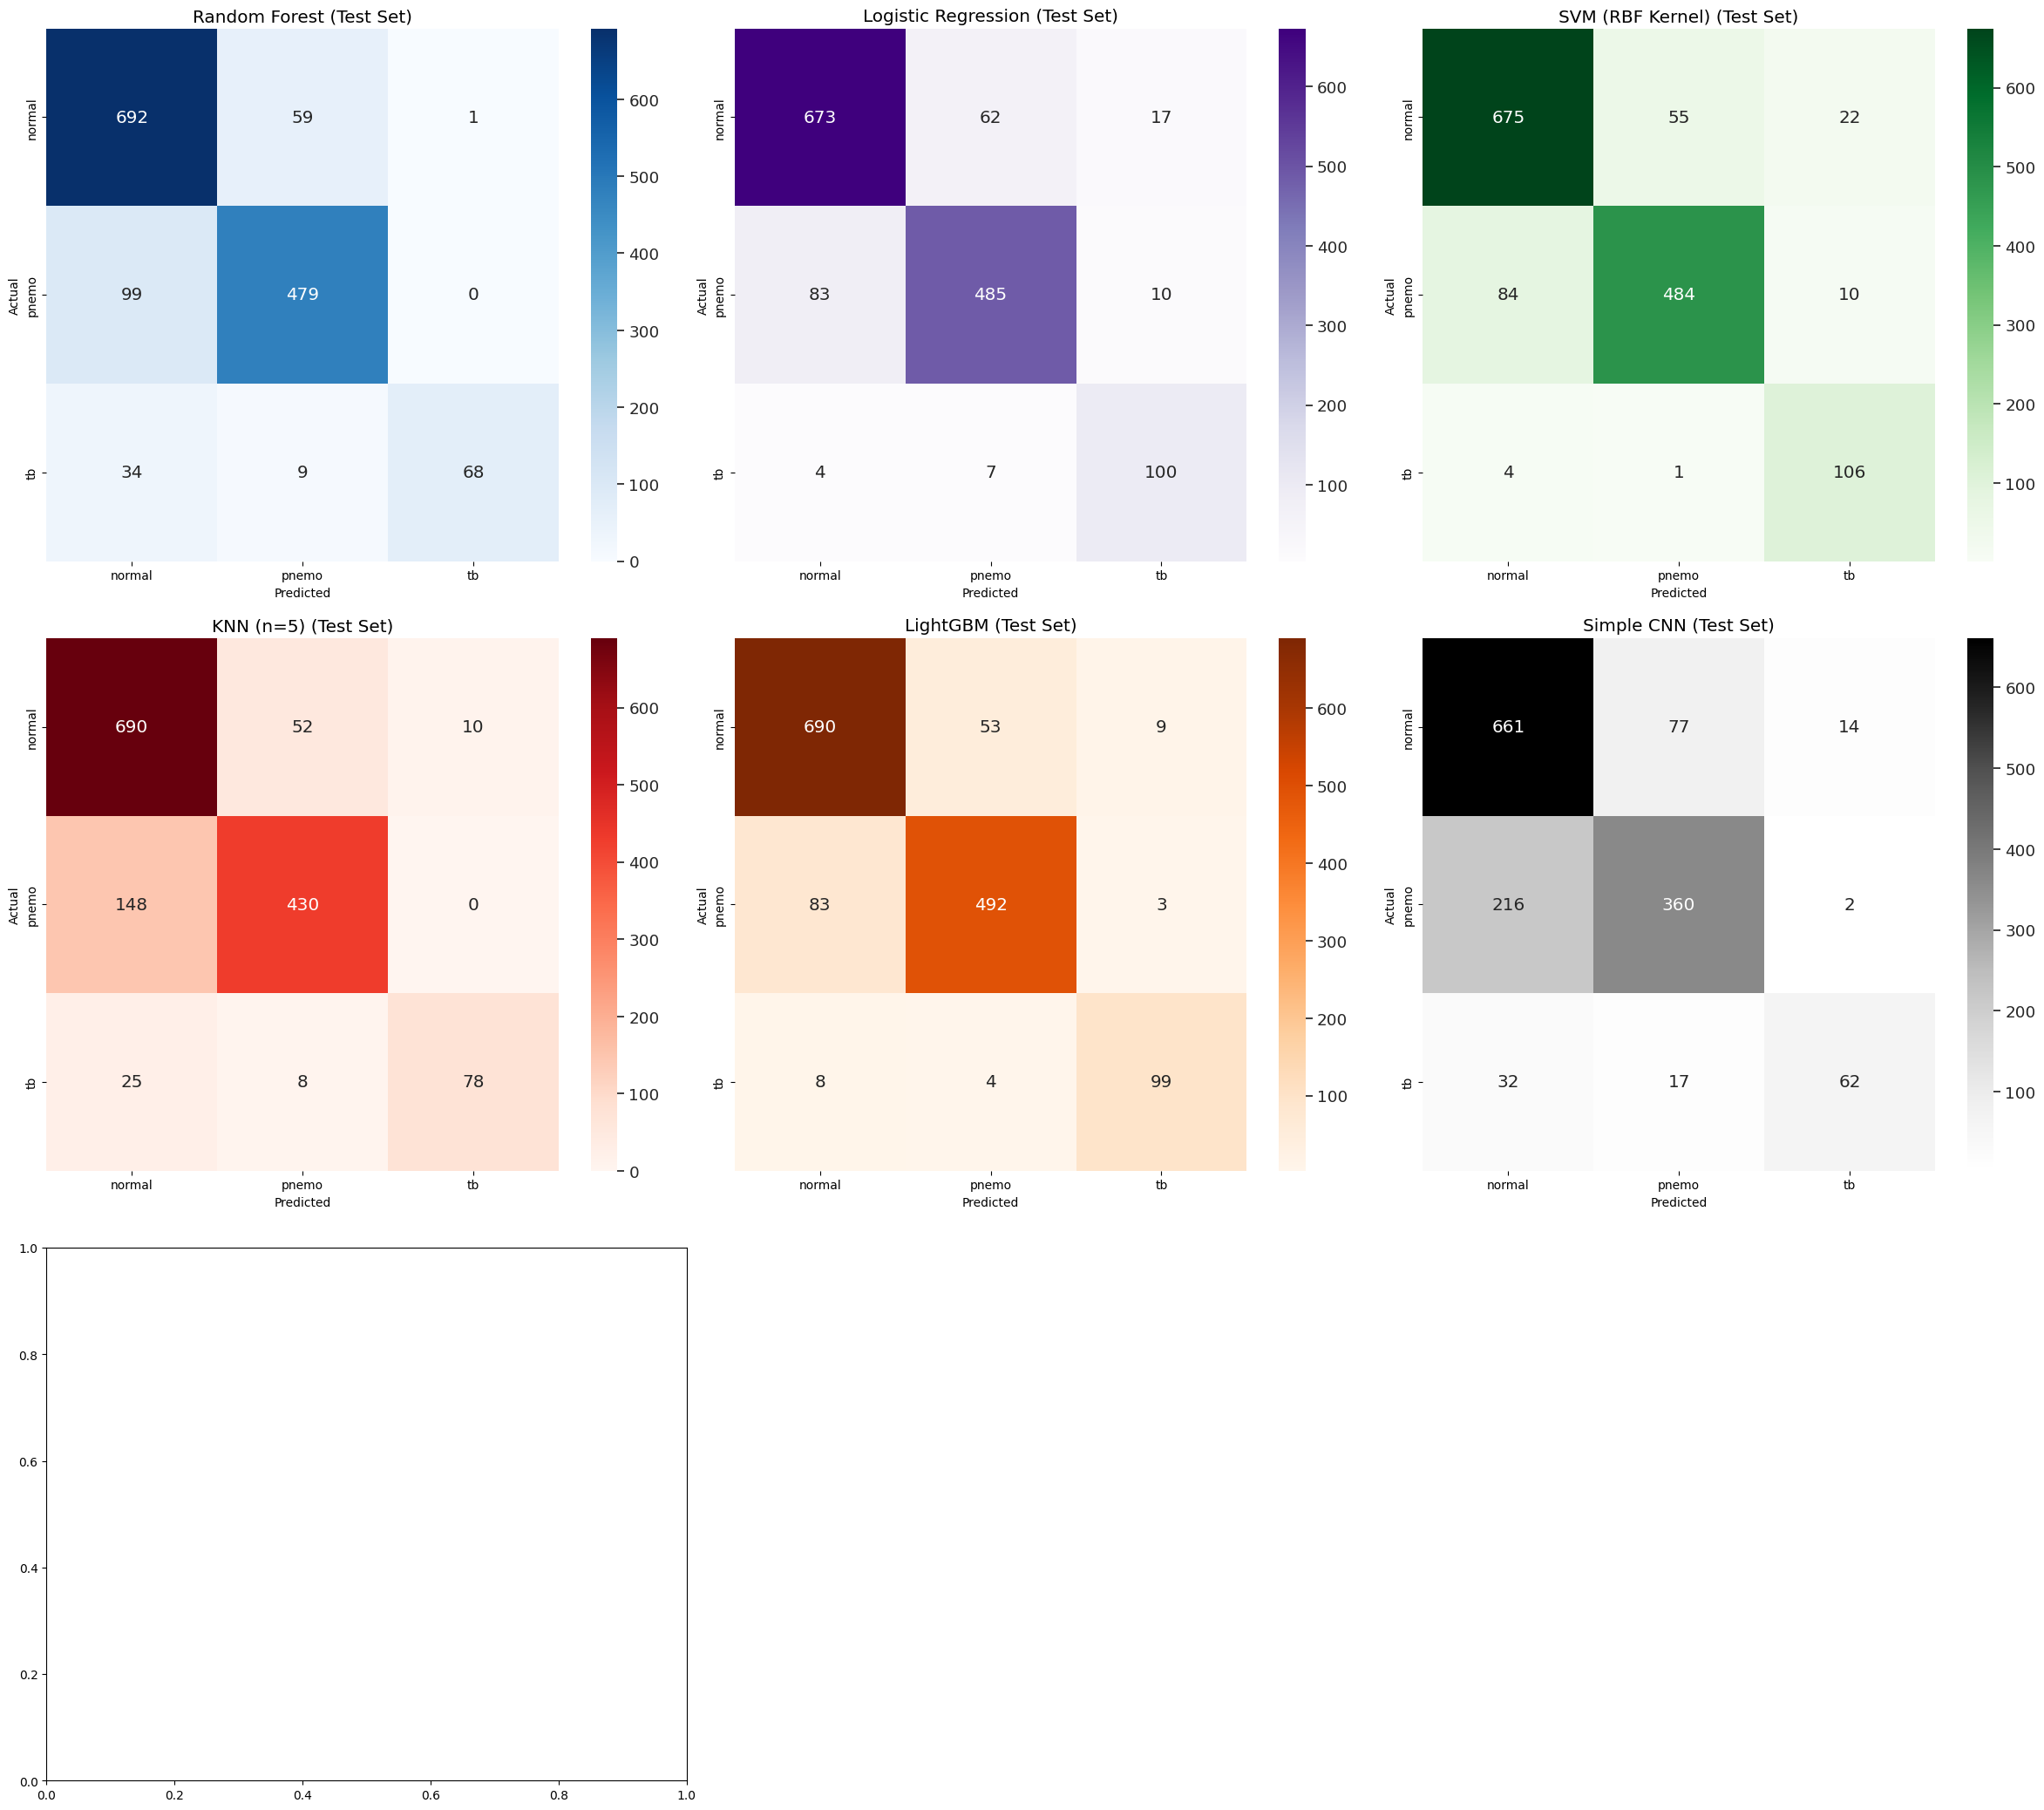


--- Plotting ROC Curves (Macro-Average) ---


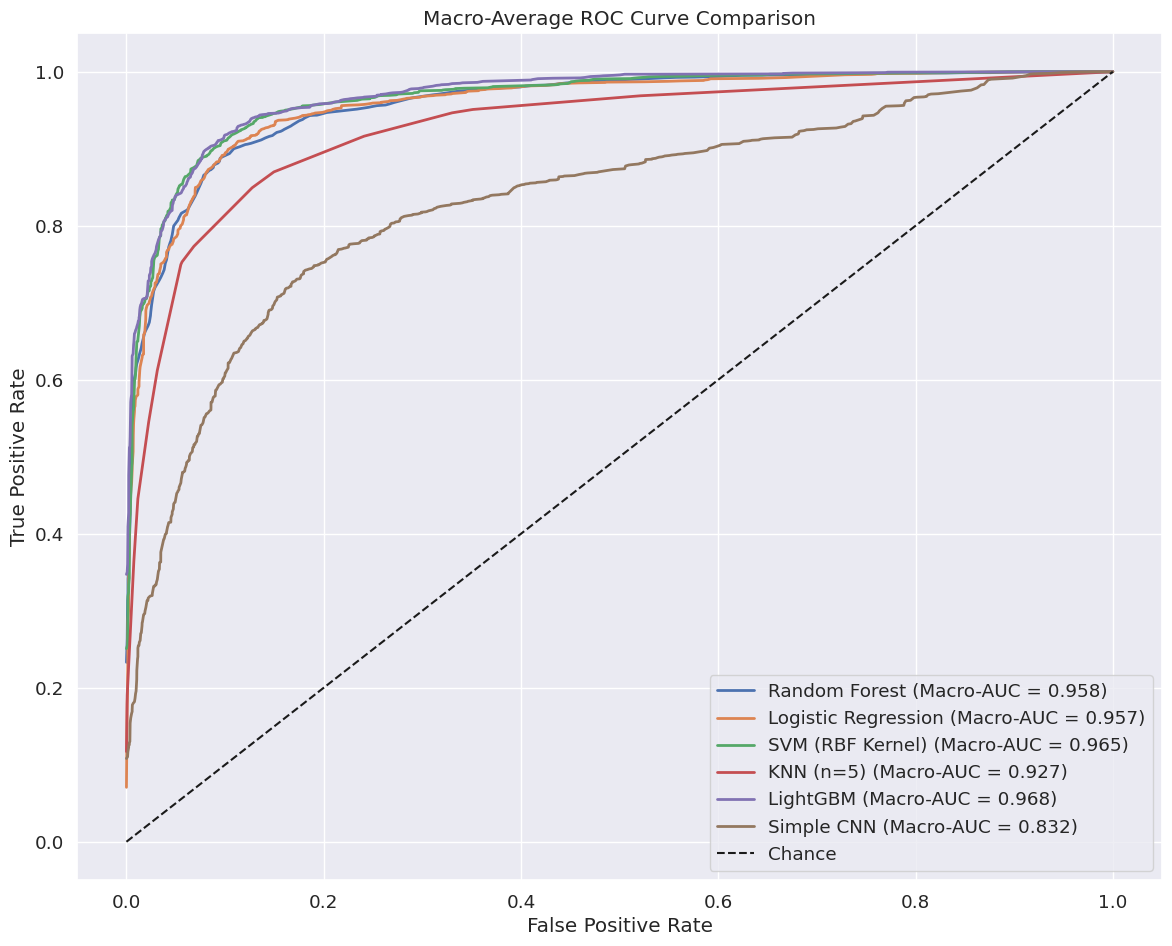


--- Final Metrics Summary ---
| Model               |   Accuracy |   Macro Precision |   Macro Recall |   Macro F1-Score |
|:--------------------|-----------:|------------------:|---------------:|-----------------:|
| LightGBM            |   0.888966 |          0.890516 |       0.886885 |         0.888401 |
| SVM (RBF Kernel)    |   0.877863 |          0.849693 |       0.896644 |         0.869442 |
| Logistic Regression |   0.873005 |          0.84946  |       0.878316 |         0.862479 |
| Random Forest       |   0.85982  |          0.899994 |       0.787182 |         0.828242 |
| KNN (n=5)           |   0.831367 |          0.854484 |       0.788067 |         0.814551 |
| Simple CNN          |   0.751561 |          0.771665 |       0.686795 |         0.716555 |


In [16]:
# --- 8. FINAL MODEL COMPARISON (ALL MODELS) ---
print("\n" + "="*30)
print(" FINAL MODEL COMPARISON ON TEST SET")
print("="*30 + "\n")

# We have the following predictions:
# y_pred_test_rf, y_prob_test_rf (from Cell 5)
# y_pred_test_lr, y_prob_test_lr (from Cell 5.5)
# y_pred_test_svm, y_prob_test_svm (from Cell 5.5)
# y_pred_test_knn, y_prob_test_knn (from Cell 5.5)
# y_pred_test_lgbm, y_prob_test_lgbm (from Cell 5.5)
# y_pred_test_cnn, y_prob_test_cnn (from Cell 6)
# y_pred_test_resnet, y_prob_test_resnet (from Cell 7)
# And the ground truth: y_test (from Cell 5)

# 1. Classification Reports
print("--- Classification Report: Random Forest ---")
print(classification_report(y_test, y_pred_test_rf, target_names=CLASSES))

print("\n--- Classification Report: Logistic Regression ---")
print(classification_report(y_test, y_pred_test_lr, target_names=CLASSES))

print("\n--- Classification Report: SVM (RBF Kernel) ---")
print(classification_report(y_test, y_pred_test_svm, target_names=CLASSES))

print("\n--- Classification Report: K-Nearest Neighbors ---")
print(classification_report(y_test, y_pred_test_knn, target_names=CLASSES))

print("\n--- Classification Report: LightGBM ---")
print(classification_report(y_test, y_pred_test_lgbm, target_names=CLASSES))

print("\n--- Classification Report: Simple CNN ---")
print(classification_report(y_test, y_pred_test_cnn, target_names=CLASSES))


# 2. Confusion Matrices
print("\n--- Plotting Confusion Matrices ---")
# We have 7 models. Let's create a 3x3 grid.
fig, ax = plt.subplots(3, 3, figsize=(24, 21))
sns.set(font_scale=1.2)
ax = ax.flatten() # Flatten the grid to loop easily

# Helper function to plot a confusion matrix
def plot_cm(y_true, y_pred, model_name, ax, cmap):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=cmap, 
                xticklabels=CLASSES, yticklabels=CLASSES)
    ax.set_title(f'{model_name} (Test Set)')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

# Plot all 7 models
plot_cm(y_test, y_pred_test_rf, 'Random Forest', ax[0], 'Blues')
plot_cm(y_test, y_pred_test_lr, 'Logistic Regression', ax[1], 'Purples')
plot_cm(y_test, y_pred_test_svm, 'SVM (RBF Kernel)', ax[2], 'Greens')
plot_cm(y_test, y_pred_test_knn, 'KNN (n=5)', ax[3], 'Reds')
plot_cm(y_test, y_pred_test_lgbm, 'LightGBM', ax[4], 'Oranges')
plot_cm(y_test, y_pred_test_cnn, 'Simple CNN', ax[5], 'Greys')

# Hide any unused subplots
for i in range(7, 9):
    ax[i].set_visible(False)

plt.tight_layout()
plt.show()

# 3. ROC Curves (One-vs-Rest for multi-class)
print("\n--- Plotting ROC Curves (Macro-Average) ---")

# Binarize the labels (y_test)
y_test_bin = label_binarize(y_test, classes=list(range(N_CLASSES)))

# Function to compute and plot macro-average ROC
def plot_macro_roc(y_true_bin, y_prob, model_name, ax):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    n_classes = y_true_bin.shape[1]
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute macro-average
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= n_classes
    
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    
    ax.plot(fpr["macro"], tpr["macro"],
             label=f'{model_name} (Macro-AUC = {roc_auc["macro"]:.3f})',
             linewidth=2)

# Plot all models
fig, ax = plt.subplots(figsize=(14, 11))

plot_macro_roc(y_test_bin, y_prob_test_rf, 'Random Forest', ax)
plot_macro_roc(y_test_bin, y_prob_test_lr, 'Logistic Regression', ax)
plot_macro_roc(y_test_bin, y_prob_test_svm, 'SVM (RBF Kernel)', ax)
plot_macro_roc(y_test_bin, y_prob_test_knn, 'KNN (n=5)', ax)
plot_macro_roc(y_test_bin, y_prob_test_lgbm, 'LightGBM', ax)
plot_macro_roc(y_test_bin, y_prob_test_cnn, 'Simple CNN', ax)

ax.plot([0, 1], [0, 1], 'k--', label='Chance')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Macro-Average ROC Curve Comparison')
ax.legend(loc='lower right')
ax.grid(True)
plt.show()

# 4. Final Comparison Table
print("\n--- Final Metrics Summary ---")

# Helper function to get macro-average metrics
def get_metrics(y_true, y_pred):
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average='macro'
    )
    accuracy = (y_true == y_pred).mean()
    return accuracy, precision, recall, f1

# Get metrics for all models
metrics_rf = get_metrics(y_test, y_pred_test_rf)
metrics_lr = get_metrics(y_test, y_pred_test_lr)
metrics_svm = get_metrics(y_test, y_pred_test_svm)
metrics_knn = get_metrics(y_test, y_pred_test_knn)
metrics_lgbm = get_metrics(y_test, y_pred_test_lgbm)
metrics_cnn = get_metrics(y_test, y_pred_test_cnn)

# Create the summary DataFrame
summary_df = pd.DataFrame({
    'Model': [
        'Random Forest', 
        'Logistic Regression', 
        'SVM (RBF Kernel)', 
        'KNN (n=5)', 
        'LightGBM', 
        'Simple CNN'
    ],
    'Accuracy': [
        metrics_rf[0], metrics_lr[0], metrics_svm[0], 
        metrics_knn[0], metrics_lgbm[0], metrics_cnn[0]
    ],
    'Macro Precision': [
        metrics_rf[1], metrics_lr[1], metrics_svm[1], 
        metrics_knn[1], metrics_lgbm[1], metrics_cnn[1]
    ],
    'Macro Recall': [
        metrics_rf[2], metrics_lr[2], metrics_svm[2], 
        metrics_knn[2], metrics_lgbm[2], metrics_cnn[2]
    ],
    'Macro F1-Score': [
        metrics_rf[3], metrics_lr[3], metrics_svm[3], 
        metrics_knn[3], metrics_lgbm[3], metrics_cnn[3]
    ]
})

# Sort by F1-Score to rank the models
summary_df = summary_df.sort_values(by='Macro F1-Score', ascending=False).reset_index(drop=True)

print(summary_df.to_markdown(index=False))

In [17]:
# --- 9. SAVE ALL TRAINED MODELS ---
import joblib

print("\n--- Saving all trained models ---")

# --- Define File Paths ---
# ML Models
rf_model_path = '/kaggle/working/random_forest_model.joblib'
lr_model_path = '/kaggle/working/logistic_regression_pipeline.joblib'
svm_model_path = '/kaggle/working/svm_pipeline.joblib'
knn_model_path = '/kaggle/working/knn_pipeline.joblib'
lgbm_model_path = '/kaggle/working/lightgbm_model.joblib'
# DL Models
cnn_model_path = '/kaggle/working/simple_cnn_model.h5'
resnet_model_path = '/kaggle/working/finetuned_resnet50_model.h5'

# --- Save ML Models (with joblib) ---
try:
    joblib.dump(rf_model, rf_model_path)
    print(f"Random Forest model saved to: {rf_model_path}")
    
    joblib.dump(lr_pipeline, lr_model_path)
    print(f"Logistic Regression pipeline saved to: {lr_model_path}")
    
    joblib.dump(svm_pipeline, svm_model_path)
    print(f"SVM pipeline saved to: {svm_model_path}")
    
    joblib.dump(knn_pipeline, knn_model_path)
    print(f"KNN pipeline saved to: {knn_model_path}")
    
    joblib.dump(lgbm_model, lgbm_model_path)
    print(f"LightGBM model saved to: {lgbm_model_path}")
    
except Exception as e:
    print(f"Error saving one or more ML models: {e}")

# --- Save DL Models (with Keras .save()) ---
try:
    simple_cnn.save(cnn_model_path)
    print(f"Simple CNN model saved to: {cnn_model_path}")
    
    finetune_model.save(resnet_model_path)
    print(f"Fine-Tuned ResNet50 model saved to: {resnet_model_path}")
except Exception as e:
    print(f"Error saving one or more DL models: {e}")

print("\nAll models have been saved to /kaggle/working/")


--- Saving all trained models ---
Random Forest model saved to: /kaggle/working/random_forest_model.joblib
Logistic Regression pipeline saved to: /kaggle/working/logistic_regression_pipeline.joblib
SVM pipeline saved to: /kaggle/working/svm_pipeline.joblib
KNN pipeline saved to: /kaggle/working/knn_pipeline.joblib
LightGBM model saved to: /kaggle/working/lightgbm_model.joblib
Simple CNN model saved to: /kaggle/working/simple_cnn_model.h5
Error saving one or more DL models: name 'finetune_model' is not defined

All models have been saved to /kaggle/working/


If you want deep learning models run the below cells

In [ ]:
# --- 7. FINE-TUNING PRE-TRAINED MODEL (ResNet50) ---
print("\n--- Building Fine-Tuned ResNet50 Model ---")

# 1. Load base model from ImageNet
base_model_resnet = ResNet50(
    weights='imagenet', 
    include_top=False,
    input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)
)

# 2. Freeze base model
base_model_resnet.trainable = False

# 3. Add custom classification head
x = base_model_resnet.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
output = Dense(N_CLASSES, activation='softmax')(x) # 3 outputs, softmax

# 4. Create new model
finetune_model = Model(inputs=base_model_resnet.input, outputs=output)

# 5. Compile (Phase 1)
finetune_model.compile(
    optimizer=Adam(learning_rate=0.001), # Higher LR for new head
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("\n--- Training Fine-Tuned Model (Phase 1: Head Only) ---")
history_finetune_1 = finetune_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=10, # Train the new head
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    callbacks=[early_stopping, reduce_lr],
    class_weight=class_weights
)

# 6. Unfreeze layers for fine-tuning (Phase 2)
print("\n--- Unfreezing top layers for fine-tuning (Phase 2) ---")
base_model_resnet.trainable = True

# Let's freeze the first 100 layers and unfreeze the rest
for layer in base_model_resnet.layers[:100]:
    layer.trainable = False
for layer in base_model_resnet.layers[100:]:
    layer.trainable = True

# 7. Re-compile with a *very* low learning rate
finetune_model.compile(
    optimizer=Adam(learning_rate=1e-5), 
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("\n--- Training Fine-Tuned Model (Phase 2: Full) ---")
history_finetune_2 = finetune_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=20, # More epochs for fine-tuning
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    callbacks=[early_stopping, reduce_lr],
    class_weight=class_weights
)

print("\n--- Evaluating Fine-Tuned ResNet50 on Test Set ---")
y_prob_test_resnet = finetune_model.predict(test_generator)
y_pred_test_resnet = np.argmax(y_prob_test_resnet, axis=1)

# Ensure prediction length matches y_test
if len(y_pred_test_resnet) != len(y_test):
    print(f"Adjusting ResNet predictions. Original: {len(y_pred_test_resnet)}, Target: {len(y_test)}")
    y_prob_test_resnet = y_prob_test_resnet[:len(y_test)]
    y_pred_test_resnet = y_pred_test_resnet[:len(y_test)]

In [ ]:
# --- 8. FINAL MODEL COMPARISON ---
print("\n" + "="*30)
print(" FINAL MODEL COMPARISON ON TEST SET")
print("="*30 + "\n")

# y_test was defined in Cell 5 and is the ground truth
# y_pred_test_rf, y_pred_test_cnn, y_pred_test_resnet are the predictions

# 1. Classification Reports
print("--- Classification Report: Random Forest ---")
print(classification_report(y_test, y_pred_test_rf, target_names=CLASSES))

print("\n--- Classification Report: Simple CNN ---")
print(classification_report(y_test, y_pred_test_cnn, target_names=CLASSES))

print("\n--- Classification Report: Fine-Tuned ResNet50 ---")
print(classification_report(y_test, y_pred_test_resnet, target_names=CLASSES))

# 2. Confusion Matrices
print("\n--- Plotting Confusion Matrices ---")
fig, ax = plt.subplots(1, 3, figsize=(24, 7))
sns.set(font_scale=1.2)

# Random Forest
cm_rf = confusion_matrix(y_test, y_pred_test_rf)
sns.heatmap(cm_rf, annot=True, fmt='d', ax=ax[0], cmap='Blues', 
            xticklabels=CLASSES, yticklabels=CLASSES)
ax[0].set_title('Random Forest (Test Set)')
ax[0].set_xlabel('Predicted')
ax[0].set_ylabel('Actual')

# Simple CNN
cm_cnn = confusion_matrix(y_test, y_pred_test_cnn)
sns.heatmap(cm_cnn, annot=True, fmt='d', ax=ax[1], cmap='Greens',
            xticklabels=CLASSES, yticklabels=CLASSES)
ax[1].set_title('Simple CNN (Test Set)')
ax[1].set_xlabel('Predicted')
ax[1].set_ylabel('Actual')

# Fine-Tuned ResNet50
cm_resnet = confusion_matrix(y_test, y_pred_test_resnet)
sns.heatmap(cm_resnet, annot=True, fmt='d', ax=ax[2], cmap='Oranges',
            xticklabels=CLASSES, yticklabels=CLASSES)
ax[2].set_title('Fine-Tuned ResNet50 (Test Set)')
ax[2].set_xlabel('Predicted')
ax[2].set_ylabel('Actual')

plt.tight_layout()
plt.show()

# 3. ROC Curves (One-vs-Rest for multi-class)
print("\n--- Plotting ROC Curves (Macro-Average) ---")

# Binarize the labels (y_test)
y_test_bin = label_binarize(y_test, classes=list(range(N_CLASSES)))

# Function to compute and plot macro-average ROC
def plot_macro_roc(y_true_bin, y_prob, model_name, ax):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for i in range(N_CLASSES):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute macro-average
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(N_CLASSES)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(N_CLASSES):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= N_CLASSES
    
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    
    ax.plot(fpr["macro"], tpr["macro"],
             label=f'{model_name} (Macro-AUC = {roc_auc["macro"]:.3f})',
             linewidth=2)

fig, ax = plt.subplots(figsize=(12, 9))

plot_macro_roc(y_test_bin, y_prob_test_rf, 'Random Forest', ax)
plot_macro_roc(y_test_bin, y_prob_test_cnn, 'Simple CNN', ax)
plot_macro_roc(y_test_bin, y_prob_test_resnet, 'Fine-Tuned ResNet50', ax)

ax.plot([0, 1], [0, 1], 'k--', label='Chance')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Macro-Average ROC Curve Comparison')
ax.legend(loc='lower right')
ax.grid(True)
plt.show()

# 4. Final Comparison Table
print("\n--- Final Metrics Summary ---")

def get_metrics(y_true, y_pred):
    # Get macro-averaged metrics
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average='macro'
    )
    # Get accuracy
    accuracy = (y_true == y_pred).mean()
    return accuracy, precision, recall, f1

metrics_rf = get_metrics(y_test, y_pred_test_rf)
metrics_cnn = get_metrics(y_test, y_pred_test_cnn)
metrics_resnet = get_metrics(y_test, y_pred_test_resnet)

summary_df = pd.DataFrame({
    'Model': ['Random Forest', 'Simple CNN', 'Fine-Tuned ResNet50'],
    'Accuracy': [metrics_rf[0], metrics_cnn[0], metrics_resnet[0]],
    'Macro Precision': [metrics_rf[1], metrics_cnn[1], metrics_resnet[1]],
    'Macro Recall': [metrics_rf[2], metrics_cnn[2], metrics_resnet[2]],
    'Macro F1-Score': [metrics_rf[3], metrics_cnn[3], metrics_resnet[3]]
})

print(summary_df.to_markdown(index=False))

In [ ]:
import joblib

print("\n--- Saving all trained models ---")

# Define file paths in the output directory
rf_model_path = '/kaggle/working/random_forest_model.joblib'
cnn_model_path = '/kaggle/working/simple_cnn_model.h5'
resnet_model_path = '/kaggle/working/finetuned_resnet50_model.h5'

# 1. Save the Random Forest model (using joblib)
try:
    joblib.dump(rf_model, rf_model_path)
    print(f"Random Forest model saved to: {rf_model_path}")
except Exception as e:
    print(f"Error saving Random Forest model: {e}")

# 2. Save the Simple CNN model (Keras .h5 format)
try:
    simple_cnn.save(cnn_model_path)
    print(f"Simple CNN model saved to: {cnn_model_path}")
except Exception as e:
    print(f"Error saving Simple CNN model: {e}")

# 3. Save the Fine-Tuned ResNet50 model (Keras .h5 format)
try:
    finetune_model.save(resnet_model_path)
    print(f"Fine-Tuned ResNet50 model saved to: {resnet_model_path}")
except Exception as e:
    print(f"Error saving Fine-Tuned ResNet50 model: {e}")

print("\nAll models have been saved.")